In [1]:
import os
# os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
%matplotlib inline
import collections
import copy
import time
import math
import inspect
import random
import pickle
# import GPUtil
import warnings
# import tiktoken
import torch
import torchvision
# import pandas as pd
# import altair as alt
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists

from torch import nn
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.nn.functional import log_softmax, pad
from torch.utils import data
from torch.utils.data import DataLoader, Dataset, Subset
from torch.optim.lr_scheduler import LambdaLR
# from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
# from torchtext.vocab import build_vocab_from_iterator
# import torchtext.datasets as datasets
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
# Set to False to skip notebook execution (e.g. for debugging)
warnings.filterwarnings("ignore")
RUN_EXAMPLES = True

# 设置打印选项，禁用科学计数法
torch.set_printoptions(sci_mode=False)

# 设置打印选项，取消显示省略号
torch.set_printoptions(threshold=float('inf'))

In [2]:
# import torch

# # 查看是否有可用的 GPU
# if torch.cuda.is_available():
#     device = torch.device("cuda")
#     print(f"CUDA Available. Using GPU: {torch.cuda.get_device_name(device)}")
#     print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(device)} bytes")
#     print(f"GPU Memory Cached: {torch.cuda.memory_reserved(device)} bytes")
# else:
#     print("CUDA not available. Using CPU.")

In [3]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [4]:
#Ensure PyTorch can utilize CUDA
use_cuda = torch.cuda.is_available()
use_cuda

True

In [5]:
# Define GPU device - We will run our model on GPU
mps_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mps_device

device(type='cuda', index=0)

In [6]:
# 查看显卡信息
!nvidia-smi

Fri Dec 20 11:43:20 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 553.35                 Driver Version: 553.35         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 5880 Ada Gene...  WDDM  |   00000000:52:00.0  On |                    0 |
| 30%   39C    P8             17W /  285W |   12113MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
# 获取系统中可用的 CUDA 设备（即 GPU）的数量
torch.cuda.device_count()

def try_gpu(i=0):  #@save
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [8]:
def try_all_gpus():  #@save
    """返回所有可用的GPU，如果没有GPU，则返回[cpu(),]"""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

In [9]:
try_gpu()

device(type='cuda', index=0)

# 🍕🍔🍕🍕Construct Neural Network 🌓🌔🌕🌖

In [10]:
class BicubicLayer(nn.Module):
    def __init__(self, size=None, scale_factor=None, in_channels=None, out_channels=None,
                 kernel_size=None, padding=None, stride=None):
        super(BicubicLayer, self).__init__()
        
        self.size = size
        self.scale_factor = scale_factor
        
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                              kernel_size=kernel_size, padding=padding, stride=stride)
        
        self.elu = nn.ELU(inplace=True)
        
    def forward(self, X):
        Y = F.interpolate(X, size=self.size, scale_factor=self.scale_factor,mode='bicubic', align_corners=False)
        Y = self.conv(Y)
        Y = self.elu(Y)
        return Y

In [11]:
net_1 = BicubicLayer(size=(16, 16), in_channels=3, out_channels=8, kernel_size=2, padding=(0, 0), stride=(1,1))
net_2 = BicubicLayer(size=(32, 32), in_channels=8, out_channels=16, kernel_size=2, padding=(0, 0), stride=1)
net_3 = BicubicLayer(size=(72, 72), in_channels=16, out_channels=32, kernel_size=3, padding=(1, 1), stride=1) 

In [12]:
# 建立整体网络结构
net_block_1 = nn.Sequential(
    net_1,
    net_2,
    net_3,).to(try_gpu())

In [13]:
from torchsummary import summary
summary(net_block_1, input_size=(3,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 15, 15]             104
               ELU-2            [-1, 8, 15, 15]               0
      BicubicLayer-3            [-1, 8, 15, 15]               0
            Conv2d-4           [-1, 16, 31, 31]             528
               ELU-5           [-1, 16, 31, 31]               0
      BicubicLayer-6           [-1, 16, 31, 31]               0
            Conv2d-7           [-1, 32, 72, 72]           4,640
               ELU-8           [-1, 32, 72, 72]               0
      BicubicLayer-9           [-1, 32, 72, 72]               0
Total params: 5,272
Trainable params: 5,272
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 4.19
Params size (MB): 0.02
Estimated Total Size (MB): 4.21
-----------------------------------------------

In [14]:
class Residual(nn.Module):  
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides) #高宽不变
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, X):
        Y =  F.relu(self.bn1(self.conv1(X)))  
        Y = self.bn2(self.conv2(Y))         
        if self.conv3:
            X = self.conv3(X)                
        Y += X
        return F.relu(Y)

In [15]:
net_4 = Residual(32,48,use_1x1conv=True)
net_5 = Residual(48,56,use_1x1conv=True)
net_6 = Residual(56,64,use_1x1conv=True)

In [16]:
# 建立整体网络结构
net_block_2 = nn.Sequential(
    net_1,
    net_2,
    net_3,
    net_4,
    net_5,
    nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
    net_6,
    nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
    ).to(try_gpu())

In [17]:
from torchsummary import summary
summary(net_block_2, input_size=(3,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 15, 15]             104
               ELU-2            [-1, 8, 15, 15]               0
      BicubicLayer-3            [-1, 8, 15, 15]               0
            Conv2d-4           [-1, 16, 31, 31]             528
               ELU-5           [-1, 16, 31, 31]               0
      BicubicLayer-6           [-1, 16, 31, 31]               0
            Conv2d-7           [-1, 32, 72, 72]           4,640
               ELU-8           [-1, 32, 72, 72]               0
      BicubicLayer-9           [-1, 32, 72, 72]               0
           Conv2d-10           [-1, 48, 72, 72]          13,872
      BatchNorm2d-11           [-1, 48, 72, 72]              96
           Conv2d-12           [-1, 48, 72, 72]          20,784
      BatchNorm2d-13           [-1, 48, 72, 72]              96
           Conv2d-14           [-1, 48,

In [18]:
class Flatten_Module(nn.Module):
    def __init__(self):
        super(Flatten_Module, self).__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(64 * 18 * 18, 400)

    def forward(self, x):

        flattened = self.flatten(x)  # Shape will be [batch_size, 64 * 9 * 9]
        linear_output = self.linear(flattened)  # Shape will be [batch_size, 1200]
        
        # Reshape to desired shape [batch_size, 20, 60]
        reshaped = linear_output.view( -1,20, 20)
        
        return reshaped

In [19]:
net_7 = Flatten_Module()

In [20]:
# 建立整体网络结构
net = nn.Sequential(
    net_1,
    net_2,
    net_3,
    net_4,
    net_5,
    nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
    net_6,
    nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
    net_7
    ).to(try_gpu())

In [21]:
from torchsummary import summary
summary(net, input_size=(3,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 15, 15]             104
               ELU-2            [-1, 8, 15, 15]               0
      BicubicLayer-3            [-1, 8, 15, 15]               0
            Conv2d-4           [-1, 16, 31, 31]             528
               ELU-5           [-1, 16, 31, 31]               0
      BicubicLayer-6           [-1, 16, 31, 31]               0
            Conv2d-7           [-1, 32, 72, 72]           4,640
               ELU-8           [-1, 32, 72, 72]               0
      BicubicLayer-9           [-1, 32, 72, 72]               0
           Conv2d-10           [-1, 48, 72, 72]          13,872
      BatchNorm2d-11           [-1, 48, 72, 72]              96
           Conv2d-12           [-1, 48, 72, 72]          20,784
      BatchNorm2d-13           [-1, 48, 72, 72]              96
           Conv2d-14           [-1, 48,

# 🍕🍔🍕🍕Trainning 🌓🌔🌕🌖

In [57]:
# Step 2: 加载 input{i}.pt 和 target{i}.pt 文件夹中的所有文件
test_folder = r'F:\ENGINE_normalized_data\test'  # 输入文件所在目录
input_files = sorted([f for f in os.listdir(test_folder) if f.startswith('input') and f.endswith('.pt')])  # 查找所有 input{i}.pt 文件
target_files = sorted([f for f in os.listdir(test_folder) if f.startswith('target') and f.endswith('.pt')])  # 查找所有 target{i}.pt 文件

# # Step 3: 只处理前 600 个文件
# input_files = input_files[:200]  # 只选择前 600 个 input 文件
# target_files = target_files[:200]  # 只选择前 600 个 target 文件

# Step 4: 初始化保存结果的列表
A_values = []  # 用于存储 A 值
predicted_outputs = []  # 用于存储预测结果
true_outputs = []  # 用于存储真实结果

# Step 5: 逐个加载 input 和 target 文件，进行预测并计算 A
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)  # 确保模型在正确的设备上

for input_file, target_file in zip(input_files, target_files):
    # 加载输入和目标张量
    input_tensor = torch.load(os.path.join(test_folder, input_file)).to(device)
    output_tensor = torch.load(os.path.join(test_folder, target_file)).to(device)
    
    # 进行预测
    with torch.no_grad():
        predicted_output = net(input_tensor.unsqueeze(0)) * target_std + target_mean   # 预测结果
        output_tensor = output_tensor * target_std + target_mean  # 转换目标张量到原始尺度
    
    # 计算 A 值
    A = (output_tensor - predicted_output) / output_tensor  # A 计算公式

    # 将预测结果、真实结果和 A 值转回 CPU 并转为 NumPy 数组 (去除 batch 维度)
    predicted_outputs.append(predicted_output.squeeze().cpu().numpy())  # 去掉 batch 维度，得到 (20, 20)
    true_outputs.append(output_tensor.squeeze().cpu().numpy())  # 去掉 batch 维度，得到 (20, 20)
    A_values.append(A.squeeze().cpu().numpy())  # 计算 A 值，并去掉 batch 维度，得到 (20, 20)

# Step 6: 将结果转换为 NumPy 数组，形状应为 (600, 20, 20)
predicted_outputs = np.array(predicted_outputs)  # 形状为 (600, 20, 20)
true_outputs = np.array(true_outputs)  # 形状为 (600, 20, 20)
A_matrix = np.array(A_values)  # 形状为 (600, 20, 20)

# 打印输出的形状
print(f"Predicted outputs shape: {predicted_outputs.shape}")  # 打印预测输出的形状
print(f"True outputs shape: {true_outputs.shape}")  # 打印真实输出的形状
print(f"A matrix shape: {A_matrix.shape}")  # 打印 A 的形状

# Step 7: 输出最后一个预测结果和真实结果
print(f"Last predicted_output: {predicted_outputs[0]}")  
print(f"Last true output_tensor: {true_outputs[0]}")  
print(f"Last A: {A_matrix[0]}") 

Predicted outputs shape: (64, 20, 20)
True outputs shape: (64, 20, 20)
A matrix shape: (64, 20, 20)
Last predicted_output: [[ 907.279    736.1929   904.5567   914.5017   941.5214   941.12976
   939.5206  1128.6995   906.5098   721.0179   741.4007   731.33496
   916.7415   884.44183  857.1775   821.34644  815.8197   911.18225
  1084.8616   884.2241 ]
 [ 644.4267   912.1507   889.5196  1116.2787  1056.365   1193.8542
  1154.6768  1085.7932   913.2107   916.63855  730.7516   920.85583
   840.43604 1012.706    905.3624   917.483    899.2023   991.62976
   834.4922   951.17596]
 [ 717.58167  918.11    1062.4448  1060.843   1023.9215  1004.34827
  1005.31726  966.4238  1017.57935  915.2298   733.00116 1115.258
   930.7143   905.80145  907.21893 1157.0958   896.43005  892.9347
   933.5634   919.3606 ]
 [1026.1595   906.4591   922.6099   998.5731   908.8952   908.2835
   901.2703  1136.0205   926.84894  906.3163  1042.2273   871.73285
   905.6616  1019.35693  920.7214   915.03235  903.2495  10

In [63]:
A_matrix_flattened = A_matrix.reshape(64, 400)

In [85]:
A_matrix_flattened.shape

(64, 400)

In [86]:
A_matrix_flattened_cut=A_matrix_flattened[0:16]

In [87]:
A_matrix_flattened_cut.shape

(16, 400)

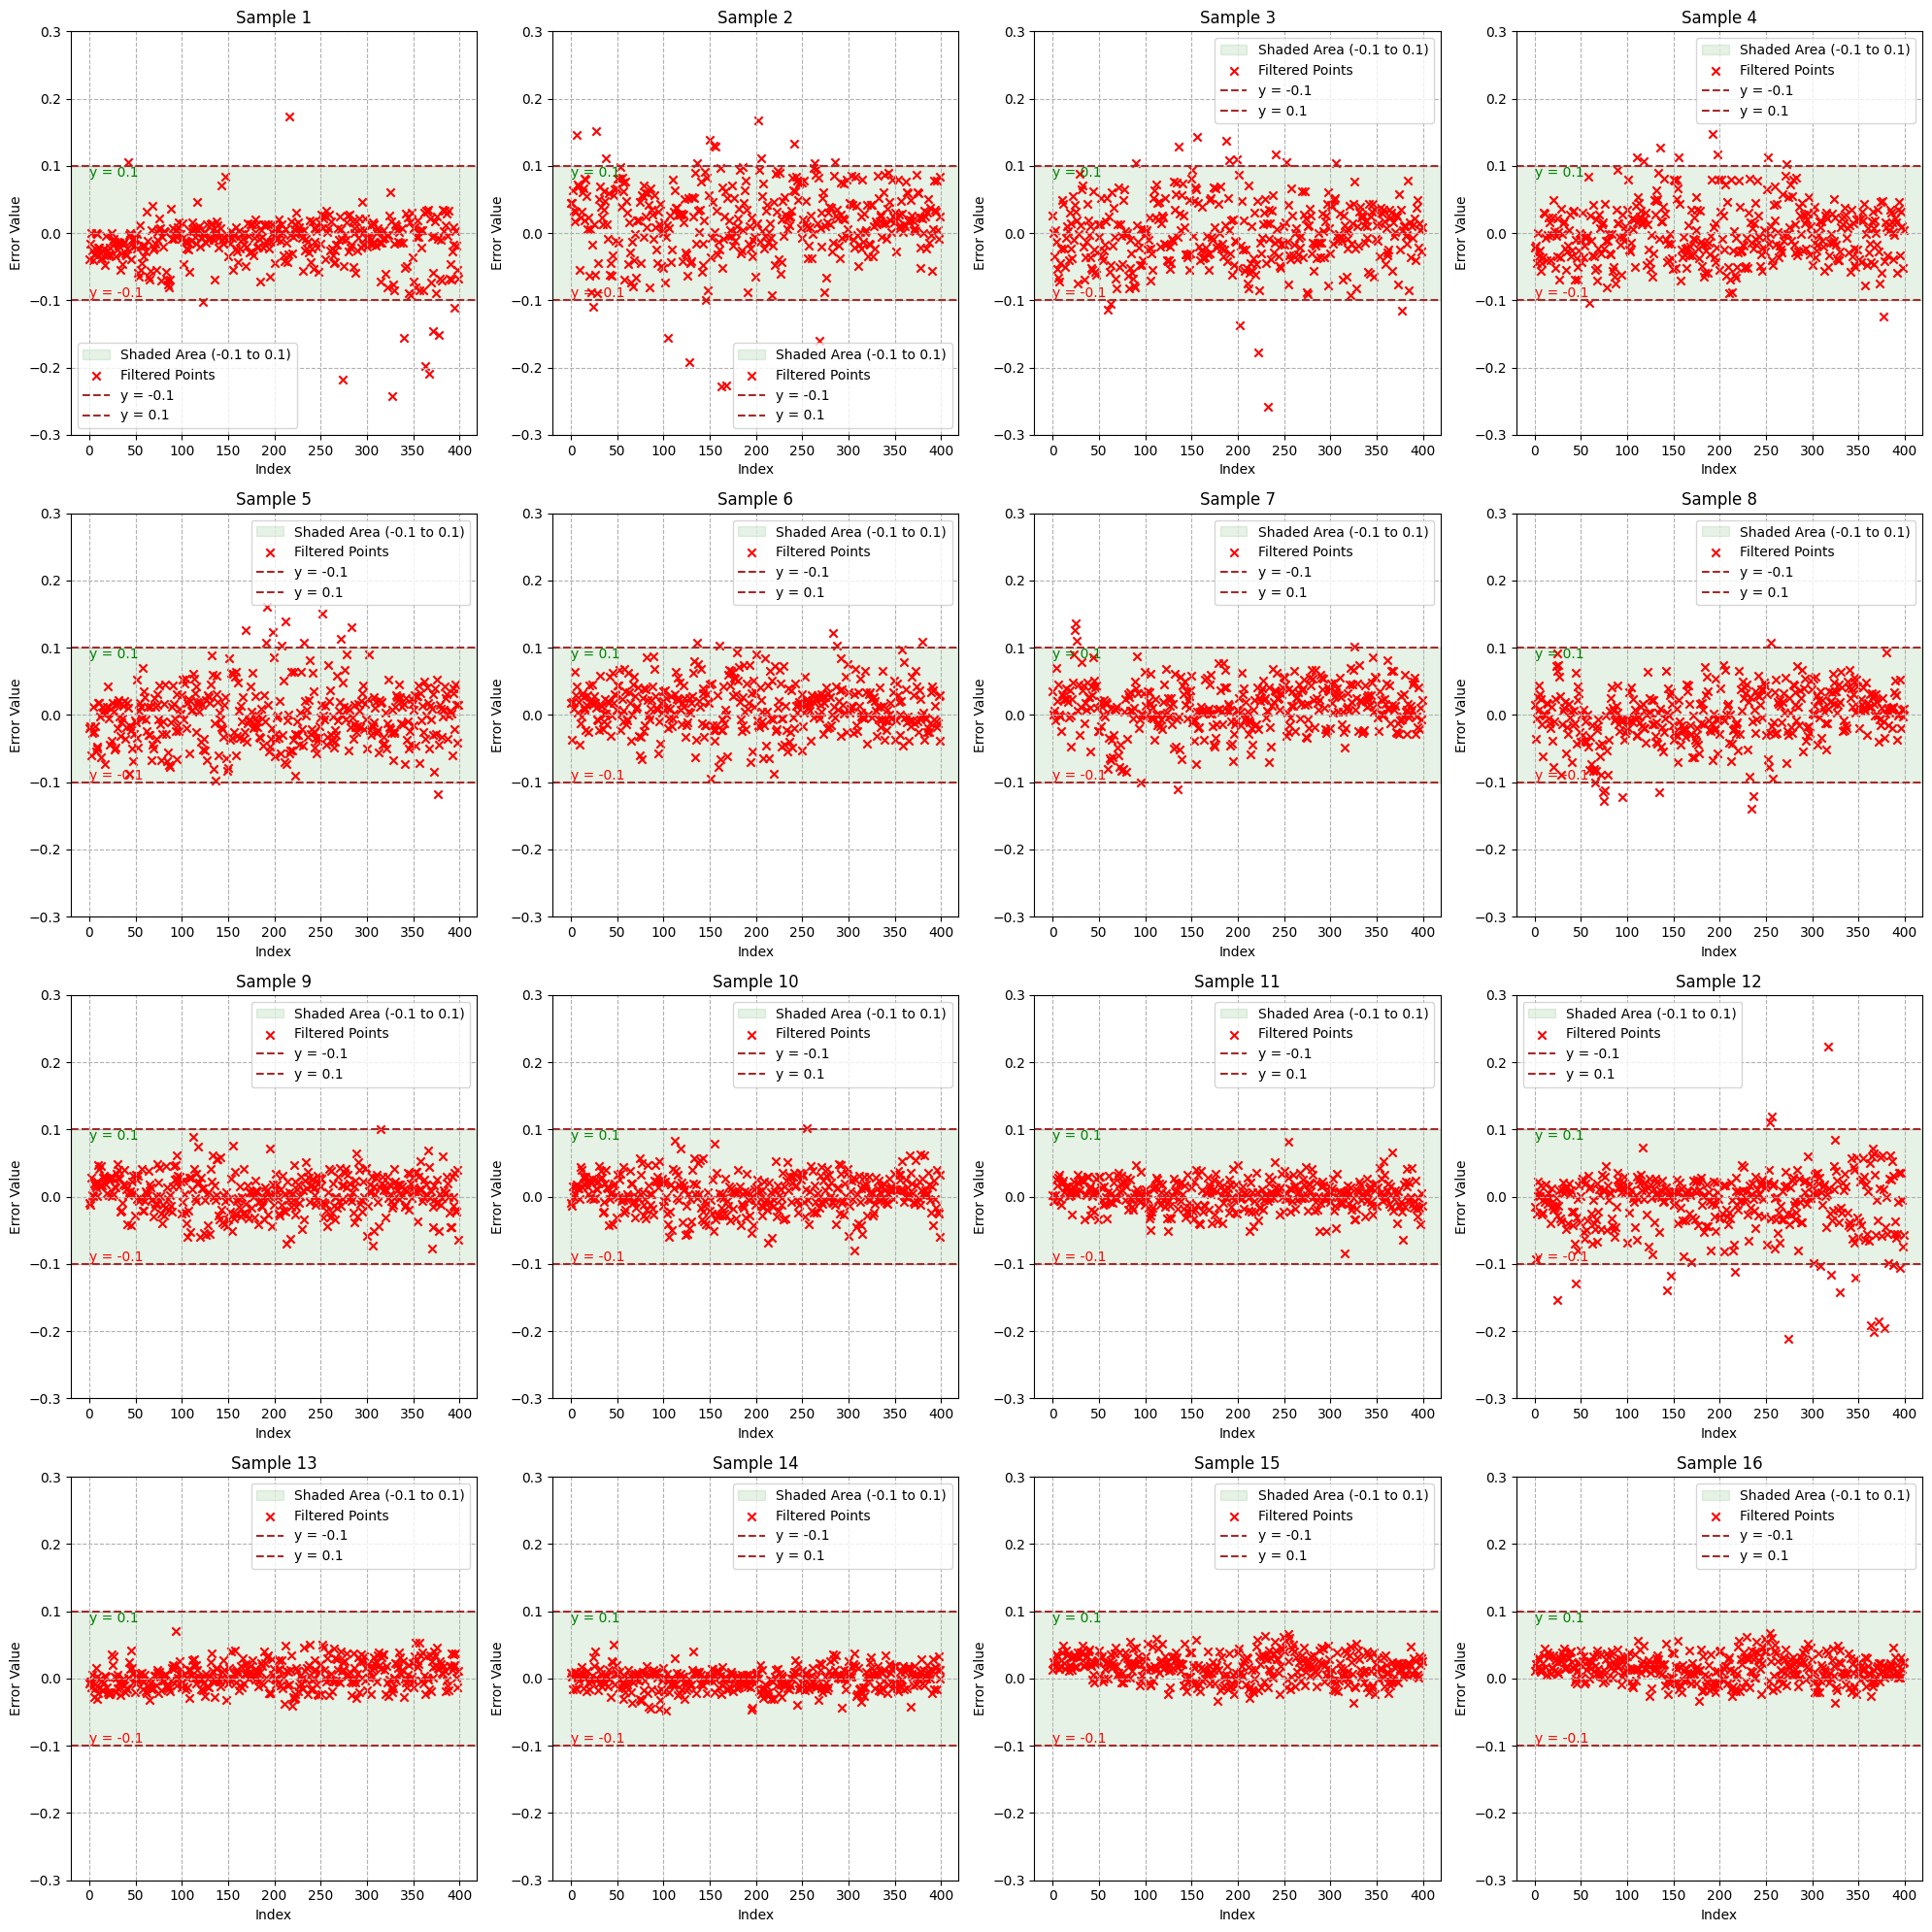

In [89]:
num_samples = A_matrix_flattened_cut.shape[0]  # 样本数量，这里是 64
samples_per_row = 4  # 每行图像数量

# 创建一个 figure 和多个子图 (8行 x 8列)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))  # 8x8 网格
axes = axes.flatten()  # 将二维数组展平，方便一一访问

# 绘制每个样本的散点图
for i in range(num_samples):
    ax = axes[i]  # 选择当前的子图
    ax.axhspan(-0.1, 0.1, color='green', alpha=0.1, label='Shaded Area (-0.1 to 0.1)')
    ax.scatter(range(400), A_matrix_flattened_cut[i], color='red', marker='x', alpha=1, label='Filtered Points')
    ax.axhline(y=-0.1, color='brown', linestyle='--', label='y = -0.1')
    ax.axhline(y=0.1, color='brown', linestyle='--', label='y = 0.1')
    ax.text(0, -0.1, 'y = -0.1', color='r', verticalalignment='bottom', horizontalalignment='left')
    ax.text(0, 0.1, 'y = 0.1', color='g', verticalalignment='top', horizontalalignment='left')
    ax.set_title(f'Sample {i+1}')
    ax.set_xlabel('Index')
    ax.set_ylim(-0.3, 0.3)
    ax.set_ylabel('Error Value')
    ax.grid(True, linestyle='--')
    ax.legend()

# 调整布局，确保子图不会重叠
plt.tight_layout()
plt.show()

In [90]:
A_matrix_flattened_cut_abs = np.abs(A_matrix_flattened_cut)

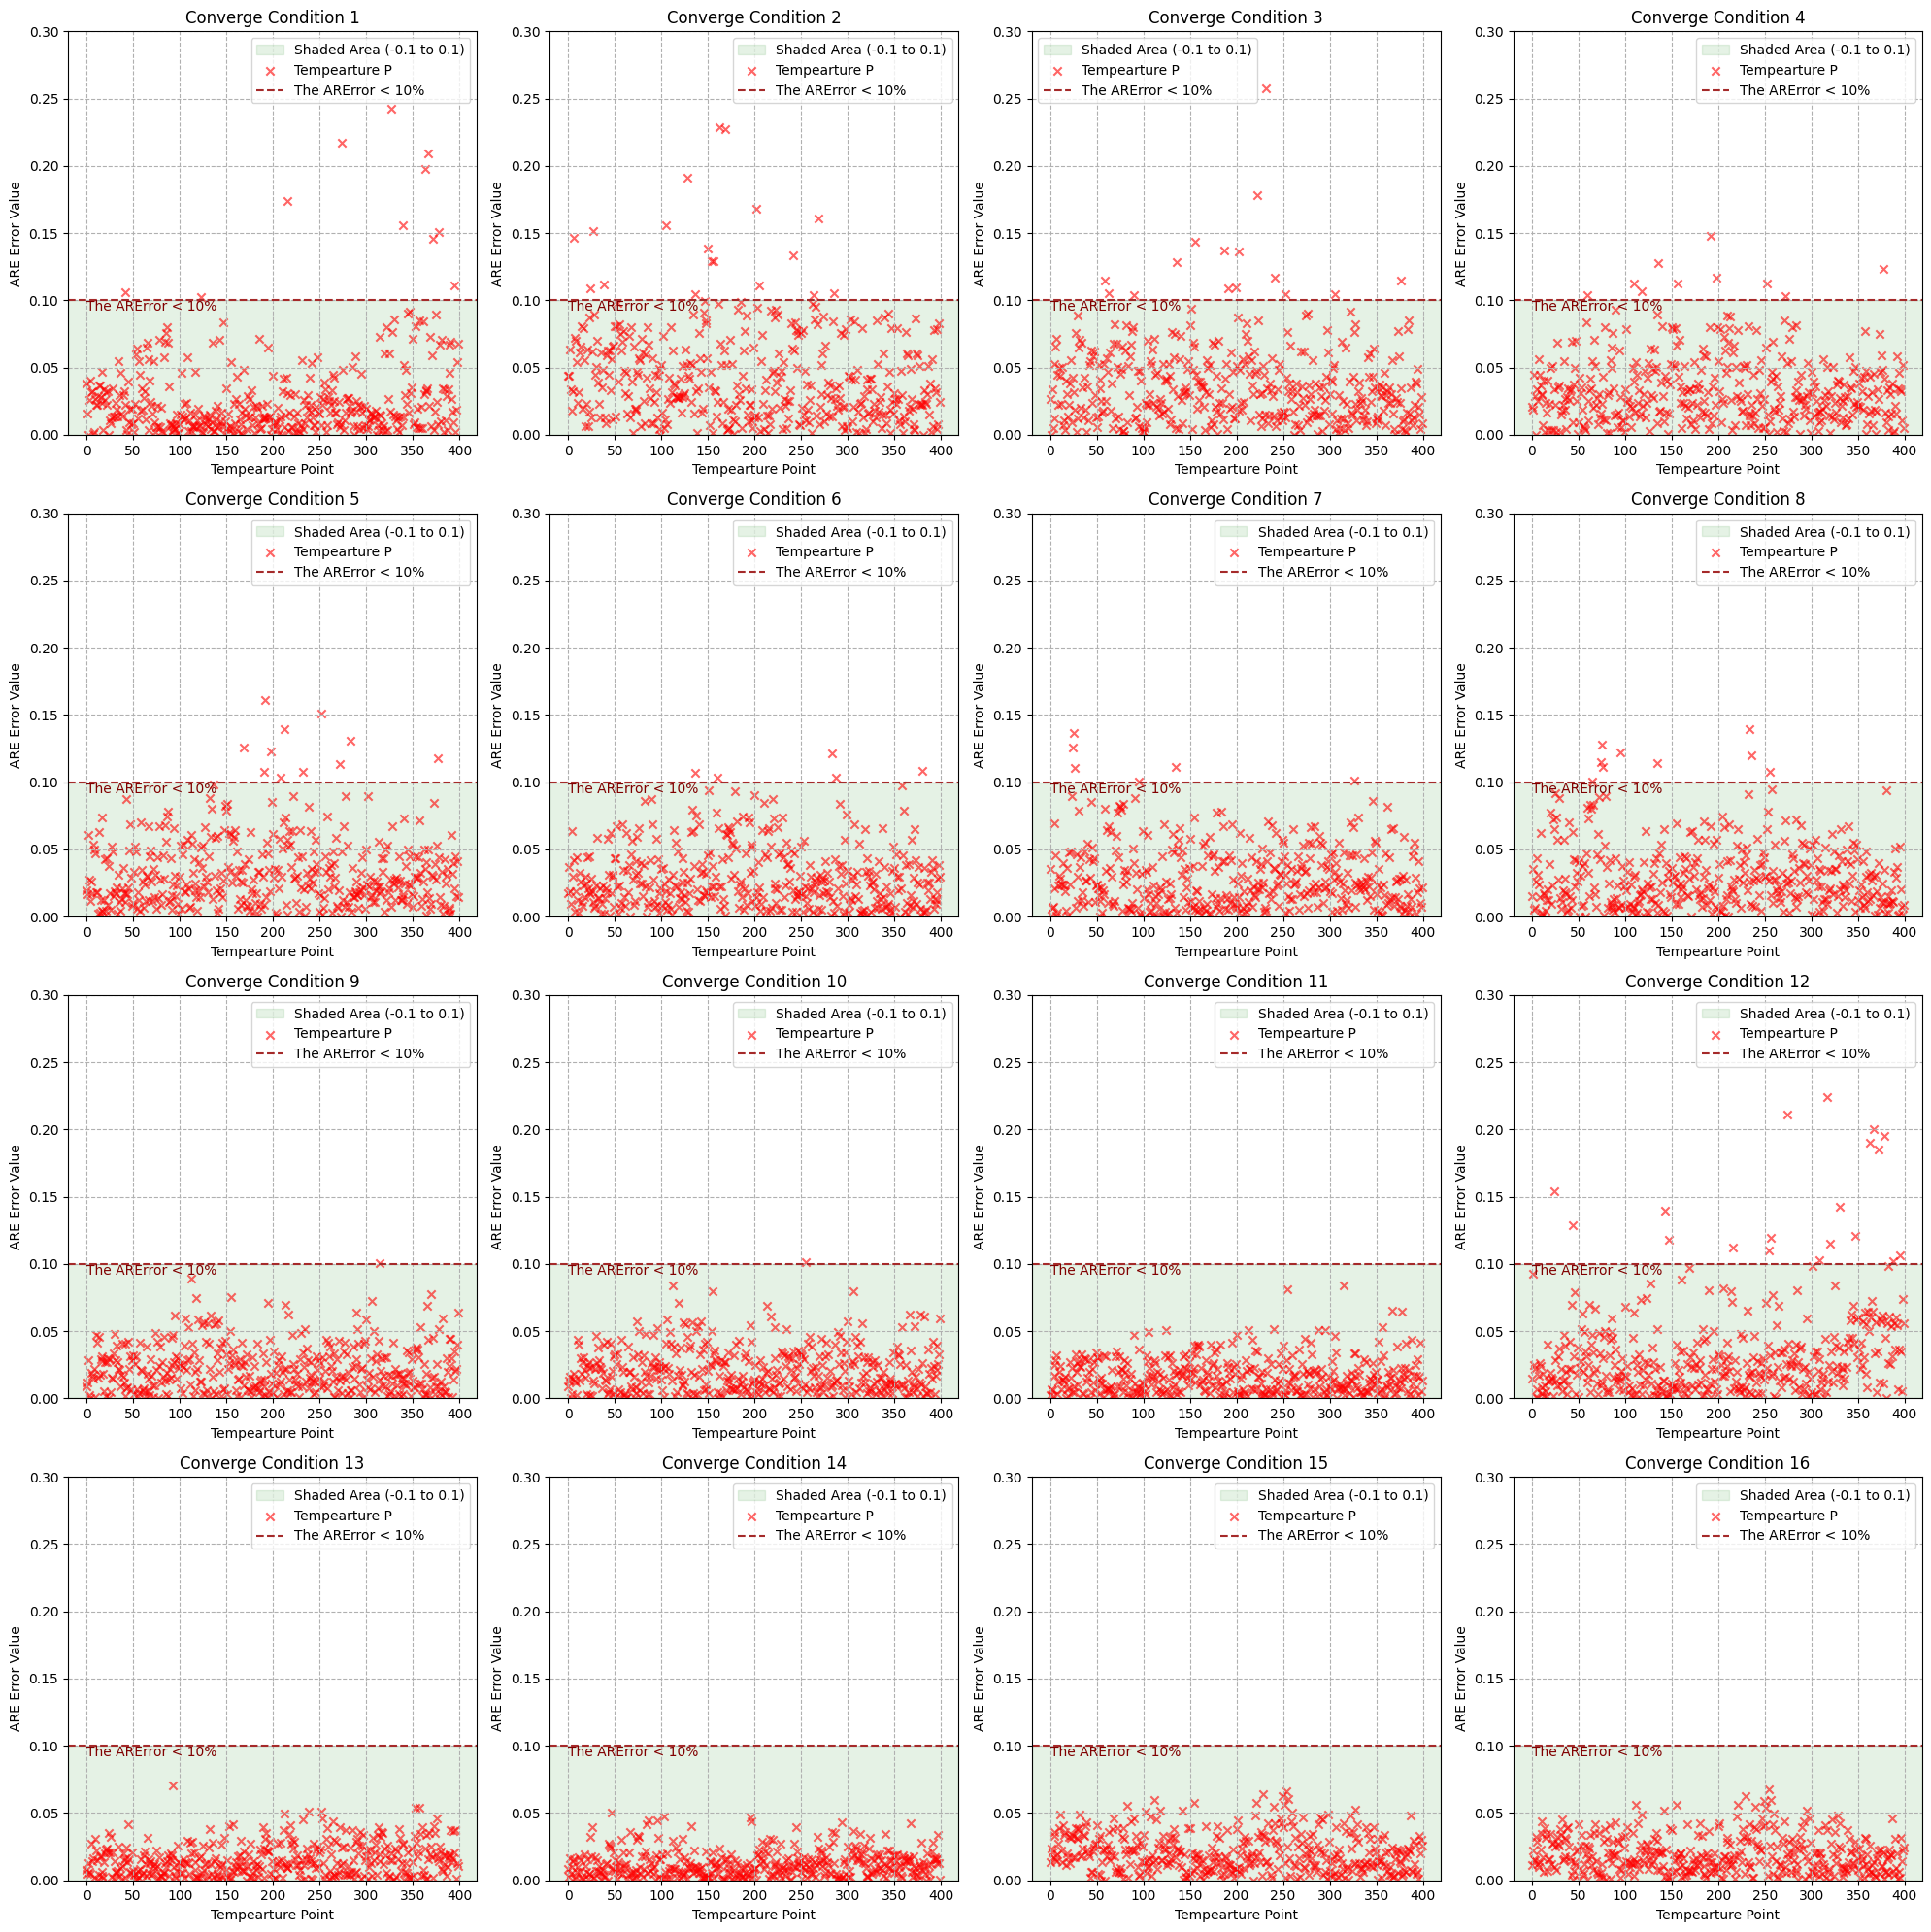

In [102]:
num_samples = A_matrix_flattened_cut_abs .shape[0]  # 样本数量，这里是 64
samples_per_row = 4  # 每行图像数量

# 创建一个 figure 和多个子图 (8行 x 8列)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))  # 8x8 网格
axes = axes.flatten()  # 将二维数组展平，方便一一访问

# 绘制每个样本的散点图
for i in range(num_samples):
    ax = axes[i]  # 选择当前的子图
    ax.axhspan(0, 0.1, color='green', alpha=0.1, label='Shaded Area (-0.1 to 0.1)')
    ax.scatter(range(400), A_matrix_flattened_cut_abs [i], color='red', marker='x', alpha=0.6, label='Tempearture P')
    ax.axhline(y=0.1, color='brown', linestyle='--', label='The ARError < 10%')
    ax.text(0, 0.1, 'The ARError < 10%', color='maroon', verticalalignment='top', horizontalalignment='left')
    ax.set_title(f'Converge Condition {i+1}')
    ax.set_xlabel('Tempearture Point')
    ax.set_ylim(0, 0.3)
    ax.set_ylabel('ARE Error Value')
    ax.grid(True, linestyle='--')
    ax.legend()

# 调整布局，确保子图不会重叠
plt.tight_layout()
plt.show()

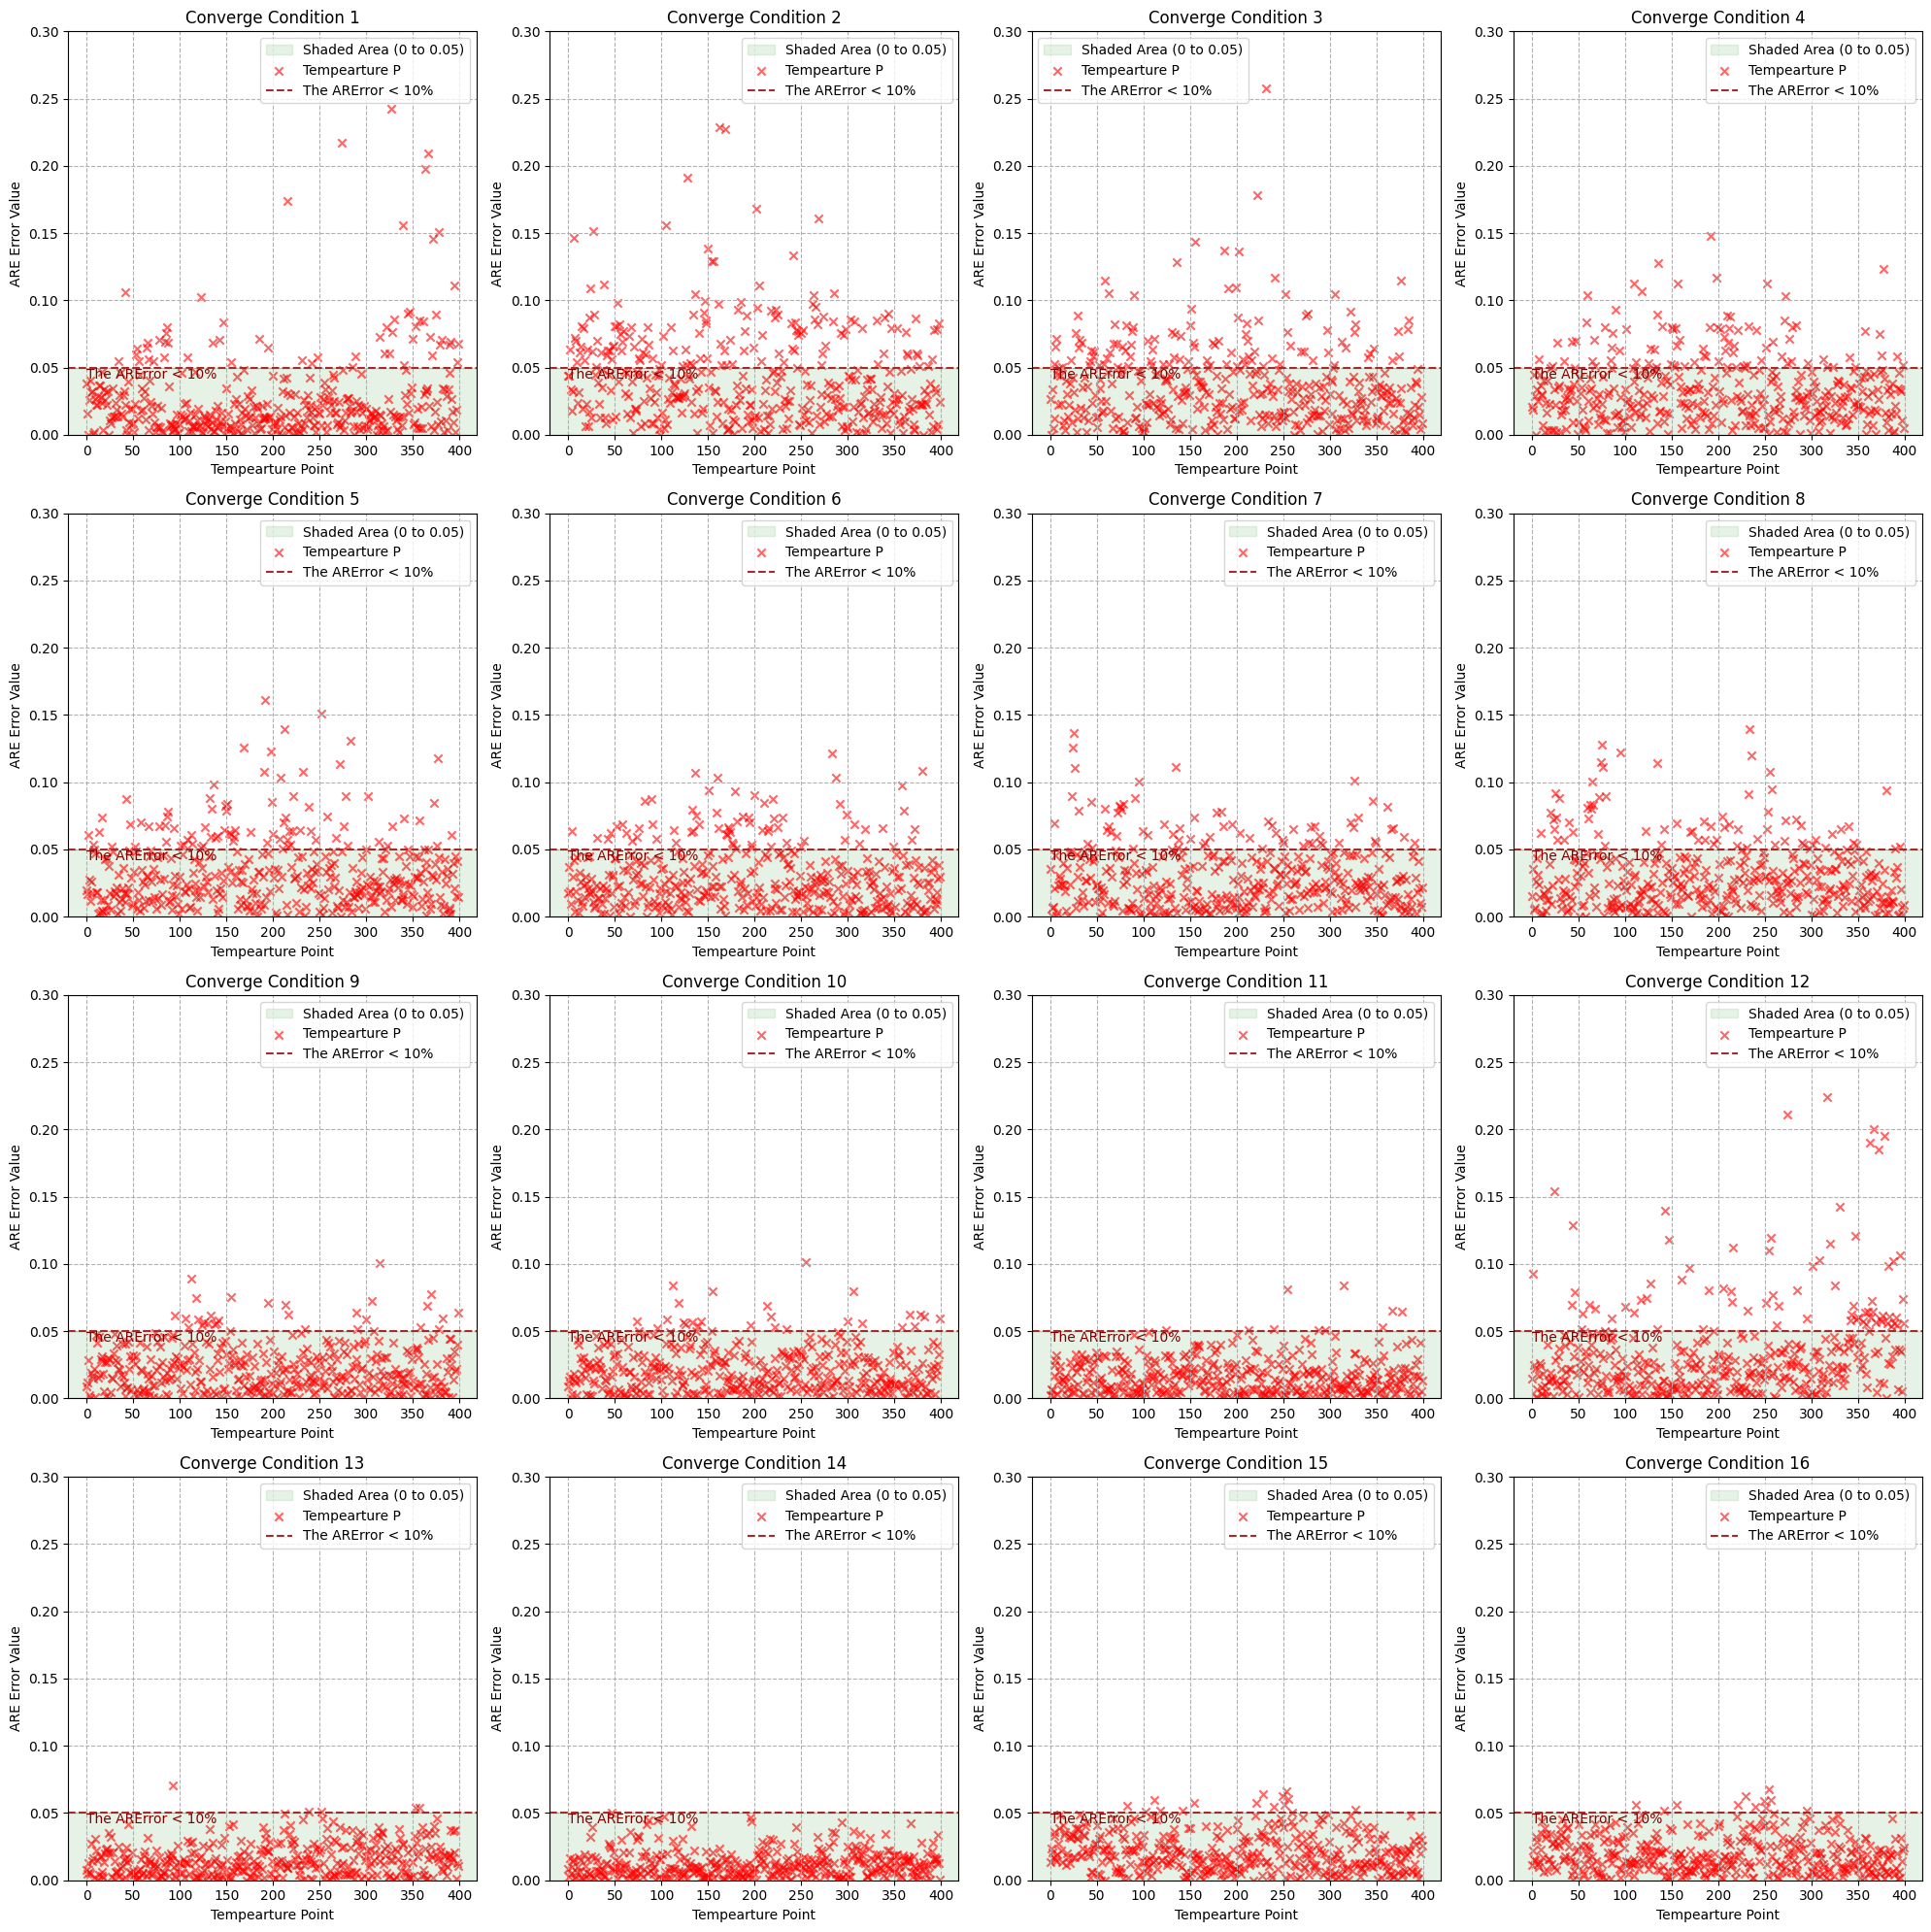

In [137]:
num_samples = A_matrix_flattened_cut_abs .shape[0]  # 样本数量，这里是 64
samples_per_row = 4  # 每行图像数量

# 创建一个 figure 和多个子图 (8行 x 8列)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))  # 8x8 网格
axes = axes.flatten()  # 将二维数组展平，方便一一访问

# 绘制每个样本的散点图
for i in range(num_samples):
    ax = axes[i]  # 选择当前的子图
    ax.axhspan(0, 0.05, color='green', alpha=0.1, label='Shaded Area (0 to 0.05)')
    ax.scatter(range(400), A_matrix_flattened_cut_abs [i], color='red', marker='x', alpha=0.6, label='Tempearture P')
    ax.axhline(y=0.05, color='brown', linestyle='--', label='The ARError < 10%')
    ax.text(0, 0.05, 'The ARError < 10%', color='maroon', verticalalignment='top', horizontalalignment='left')
    ax.set_title(f'Converge Condition {i+1}')
    ax.set_xlabel('Tempearture Point')
    ax.set_ylim(0, 0.3)
    ax.set_ylabel('ARE Error Value')
    ax.grid(True, linestyle='--')
    ax.legend()

# 调整布局，确保子图不会重叠
plt.tight_layout()
plt.show()

In [120]:
tensor_raw_input = torch.load(os.path.join(r'F:\ptdatav3\1500', f'input-{1}.pt')).to(mps_device)
print(f"Tensor dtype: {tensor_raw_input.dtype}")
print(f"Tensor shape: {tensor_raw_input.shape}")
print(f"Tensor device: {tensor_raw_input.device}")
print(f"Tensor content: {tensor_raw_input}")

Tensor dtype: torch.float32
Tensor shape: torch.Size([2, 2, 2])
Tensor device: cuda:0
Tensor content: tensor([[[112896.7969, 112901.3125],
         [112896.7969, 112901.3125]],

        [[  1500.0000,   -402.5000],
         [  1500.0000,   -402.5000]]], device='cuda:0')


In [121]:
tensor_raw_input = torch.load(os.path.join(r'F:\ptdatav3\1500', f'input-{2}.pt')).to(mps_device)
print(f"Tensor dtype: {tensor_raw_input.dtype}")
print(f"Tensor shape: {tensor_raw_input.shape}")
print(f"Tensor device: {tensor_raw_input.device}")
print(f"Tensor content: {tensor_raw_input}")

Tensor dtype: torch.float32
Tensor shape: torch.Size([2, 2, 2])
Tensor device: cuda:0
Tensor content: tensor([[[112896.7969, 112901.3125],
         [112896.7969, 112901.3125]],

        [[  1500.0000,   -402.5000],
         [  1500.0000,   -402.5000]]], device='cuda:0')


In [122]:
tensor_raw_input = torch.load(os.path.join(r'F:\ptdatav3\1500', f'input-{3}.pt')).to(mps_device)
print(f"Tensor dtype: {tensor_raw_input.dtype}")
print(f"Tensor shape: {tensor_raw_input.shape}")
print(f"Tensor device: {tensor_raw_input.device}")
print(f"Tensor content: {tensor_raw_input}")

Tensor dtype: torch.float32
Tensor shape: torch.Size([2, 2, 2])
Tensor device: cuda:0
Tensor content: tensor([[[112752.2109, 113495.1484],
         [112750.7969, 113490.5234]],

        [[  1500.0000,   -402.3630],
         [  1500.0000,   -402.3630]]], device='cuda:0')


In [129]:
tensor_raw_input = torch.load(os.path.join(r'F:\ptdatav3\1500', f'input-{309}.pt')).to(mps_device)
print(f"Tensor dtype: {tensor_raw_input.dtype}")
print(f"Tensor shape: {tensor_raw_input.shape}")
print(f"Tensor device: {tensor_raw_input.device}")
print(f"Tensor content: {tensor_raw_input}")

Tensor dtype: torch.float32
Tensor shape: torch.Size([2, 2, 2])
Tensor device: cuda:0
Tensor content: tensor([[[108097.5938, 105262.4062],
         [107862.5625, 104911.4766]],

        [[  1500.0000,   -364.1250],
         [  1500.0000,   -364.1250]]], device='cuda:0')


In [131]:
tensor_raw_input = torch.load(os.path.join(r'F:\ptdatav3\1500', f'input-{3179}.pt')).to(mps_device)
print(f"Tensor dtype: {tensor_raw_input.dtype}")
print(f"Tensor shape: {tensor_raw_input.shape}")
print(f"Tensor device: {tensor_raw_input.device}")
print(f"Tensor content: {tensor_raw_input}")

Tensor dtype: torch.float32
Tensor shape: torch.Size([2, 2, 2])
Tensor device: cuda:0
Tensor content: tensor([[[ 2.7507e+06,  2.7514e+06],
         [ 2.7508e+06,  2.7510e+06]],

        [[ 1.5000e+03, -5.3669e+00],
         [ 1.5000e+03, -5.3669e+00]]], device='cuda:0')


In [132]:
tensor_raw_input = torch.load(os.path.join(r'F:\1500v2', f'input-{1}_modified.pt')).to(mps_device)

# 打印张量的基本信息
print(f"Tensor dtype: {tensor_raw_input.dtype}")
print(f"Tensor shape: {tensor_raw_input.shape}")
print(f"Tensor device: {tensor_raw_input.device}")
print(f"Tensor content: {tensor_raw_input}")

Tensor dtype: torch.float32
Tensor shape: torch.Size([3, 1, 1])
Tensor device: cuda:0
Tensor content: tensor([[[  1500.0000]],

        [[  -402.5000]],

        [[112896.7969]]], device='cuda:0')


In [133]:
tensor_raw_input = torch.load(os.path.join(r'F:\1500v2', f'input-{2}_modified.pt')).to(mps_device)

# 打印张量的基本信息
print(f"Tensor dtype: {tensor_raw_input.dtype}")
print(f"Tensor shape: {tensor_raw_input.shape}")
print(f"Tensor device: {tensor_raw_input.device}")
print(f"Tensor content: {tensor_raw_input}")

Tensor dtype: torch.float32
Tensor shape: torch.Size([3, 1, 1])
Tensor device: cuda:0
Tensor content: tensor([[[  1500.0000]],

        [[  -402.5000]],

        [[112896.7969]]], device='cuda:0')


In [134]:
tensor_raw_input = torch.load(os.path.join(r'F:\1500v2', f'input-{3}_modified.pt')).to(mps_device)

# 打印张量的基本信息
print(f"Tensor dtype: {tensor_raw_input.dtype}")
print(f"Tensor shape: {tensor_raw_input.shape}")
print(f"Tensor device: {tensor_raw_input.device}")
print(f"Tensor content: {tensor_raw_input}")

Tensor dtype: torch.float32
Tensor shape: torch.Size([3, 1, 1])
Tensor device: cuda:0
Tensor content: tensor([[[  1500.0000]],

        [[  -402.3630]],

        [[112649.0625]]], device='cuda:0')


In [126]:
tensor_raw_input = torch.load(os.path.join(r'F:\1500v2', f'output-{1}.pt')).to(mps_device)

# 打印张量的基本信息
print(f"Tensor dtype: {tensor_raw_input.dtype}")
print(f"Tensor shape: {tensor_raw_input.shape}")
print(f"Tensor device: {tensor_raw_input.device}")
print(f"Tensor content: {tensor_raw_input}")

Tensor dtype: torch.float32
Tensor shape: torch.Size([20, 20])
Tensor device: cuda:0
Tensor content: tensor([[1203.2000, 1203.2000, 1203.2104, 1203.2000, 1203.2000, 1203.2000,
         1203.2000, 1203.2000, 1203.2104, 1203.2000, 1203.2000, 1203.2000,
         1203.2000, 1203.2000, 1203.2000, 1203.2000, 1203.2000, 1203.2104,
         1203.2000, 1203.2000],
        [1203.2000, 1203.2000, 1203.2000, 1203.2000, 1203.2000, 1203.2000,
         1203.2000, 1203.2000, 1203.2000, 1203.2104, 1203.2000, 1203.2000,
         1203.2000, 1203.2000, 1203.2104, 1203.2000, 1203.2104, 1203.2000,
         1203.2000, 1203.2000],
        [1203.2000, 1203.2104, 1203.2000, 1203.2000, 1203.2000, 1203.2000,
         1203.2000, 1203.2000, 1203.2000, 1203.2104, 1203.2000, 1203.2000,
         1203.2000, 1203.2104, 1203.2104, 1203.2000, 1203.2104, 1203.2104,
         1203.2000, 1203.2000],
        [1203.2000, 1203.2000, 1203.2000, 1203.2000, 1203.2104, 1203.2104,
         1203.2104, 1203.2000, 1203.2000, 1203.2000, 

In [127]:
tensor_raw_input = torch.load(os.path.join(r'F:\1500v2', f'output-{2}.pt')).to(mps_device)

# 打印张量的基本信息
print(f"Tensor dtype: {tensor_raw_input.dtype}")
print(f"Tensor shape: {tensor_raw_input.shape}")
print(f"Tensor device: {tensor_raw_input.device}")
print(f"Tensor content: {tensor_raw_input}")

Tensor dtype: torch.float32
Tensor shape: torch.Size([20, 20])
Tensor device: cuda:0
Tensor content: tensor([[1203.2000, 1203.2000, 1203.2104, 1203.2000, 1203.2000, 1203.2000,
         1203.2000, 1203.2000, 1203.2104, 1203.2000, 1203.2000, 1203.2000,
         1203.2000, 1203.2000, 1203.2000, 1203.2000, 1203.2000, 1203.2104,
         1203.2000, 1203.2000],
        [1203.2000, 1203.2000, 1203.2000, 1203.2000, 1203.2000, 1203.2000,
         1203.2000, 1203.2000, 1203.2000, 1203.2104, 1203.2000, 1203.2000,
         1203.2000, 1203.2000, 1203.2104, 1203.2000, 1203.2104, 1203.2000,
         1203.2000, 1203.2000],
        [1203.2000, 1203.2104, 1203.2000, 1203.2000, 1203.2000, 1203.2000,
         1203.2000, 1203.2000, 1203.2000, 1203.2104, 1203.2000, 1203.2000,
         1203.2000, 1203.2104, 1203.2104, 1203.2000, 1203.2104, 1203.2104,
         1203.2000, 1203.2000],
        [1203.2000, 1203.2000, 1203.2000, 1203.2000, 1203.2104, 1203.2104,
         1203.2104, 1203.2000, 1203.2000, 1203.2000, 

In [128]:
tensor_raw_input = torch.load(os.path.join(r'F:\1500v2', f'output-{3}.pt')).to(mps_device)

# 打印张量的基本信息
print(f"Tensor dtype: {tensor_raw_input.dtype}")
print(f"Tensor shape: {tensor_raw_input.shape}")
print(f"Tensor device: {tensor_raw_input.device}")
print(f"Tensor content: {tensor_raw_input}")

Tensor dtype: torch.float32
Tensor shape: torch.Size([20, 20])
Tensor device: cuda:0
Tensor content: tensor([[1190.4287, 1114.1659, 1184.6498, 1193.4397, 1191.8822, 1191.9978,
         1192.1405, 1202.3964, 1184.6469, 1143.9330, 1161.9065, 1161.3906,
         1201.4102, 1192.6779, 1189.1786, 1184.5240, 1181.1613, 1183.2407,
         1202.4480, 1187.1747],
        [1079.5770, 1191.9989, 1183.9578, 1202.0718, 1169.2279, 1201.9061,
         1200.6592, 1202.1360, 1184.8638, 1184.6447, 1163.1161, 1201.0968,
         1186.9092, 1202.4213, 1180.5730, 1201.1415, 1180.5690, 1202.3396,
         1186.1252, 1201.8257],
        [1143.7277, 1184.8698, 1201.4888, 1188.1150, 1179.2822, 1191.8630,
         1180.3740, 1189.3486, 1201.4415, 1184.8597, 1160.7192, 1202.7571,
         1201.7275, 1178.4768, 1174.5978, 1202.8967, 1175.6481, 1178.5627,
         1201.7682, 1200.8303],
        [1202.1204, 1185.4202, 1183.1826, 1194.6648, 1182.1304, 1181.3335,
         1182.1354, 1202.5021, 1183.3927, 1184.9760, 

In [135]:
tensor_raw_input = torch.load(os.path.join(r'F:\1500v2', f'output-{309}.pt')).to(mps_device)

# 打印张量的基本信息
print(f"Tensor dtype: {tensor_raw_input.dtype}")
print(f"Tensor shape: {tensor_raw_input.shape}")
print(f"Tensor device: {tensor_raw_input.device}")
print(f"Tensor content: {tensor_raw_input}")

Tensor dtype: torch.float32
Tensor shape: torch.Size([20, 20])
Tensor device: cuda:0
Tensor content: tensor([[ 416.5834,  426.4382,  642.0103,  616.6574,  438.4696,  425.3188,
          426.6562,  654.2009,  656.2220,  428.0905,  439.9498,  470.8067,
          472.9527,  632.6414,  441.0366,  498.6500,  426.8079,  619.4138,
          578.9845,  462.3304],
        [ 416.0091,  444.5154,  533.5609,  435.4467,  587.2184,  468.0093,
          465.8927,  548.1370,  539.1617,  456.9333,  371.0563,  484.6594,
          474.4418,  483.1233,  492.3738,  483.4902,  488.9012,  446.0535,
          466.8797,  478.1093],
        [ 446.2574,  420.0395,  894.1161,  819.5533,  484.3073,  507.9475,
          572.8924,  867.1985,  764.3646,  430.5710,  407.3719,  395.3391,
         1150.9407,  622.7431,  445.8633,  451.0853,  449.7840,  608.1000,
         1132.9214,  382.6057],
        [ 417.9270,  504.3470,  430.1608,  448.9882,  459.3045,  520.0687,
          516.4288,  499.3577,  430.0282,  463.2624, 

In [136]:
tensor_raw_input = torch.load(os.path.join(r'F:\1500v2', f'output-{3179}.pt')).to(mps_device)

# 打印张量的基本信息
print(f"Tensor dtype: {tensor_raw_input.dtype}")
print(f"Tensor shape: {tensor_raw_input.shape}")
print(f"Tensor device: {tensor_raw_input.device}")
print(f"Tensor content: {tensor_raw_input}")

Tensor dtype: torch.float32
Tensor shape: torch.Size([20, 20])
Tensor device: cuda:0
Tensor content: tensor([[699.0141, 695.9914, 693.6721, 708.2117, 689.9551, 695.2680, 691.3990,
         712.0675, 696.6580, 714.4199, 701.0945, 701.9583, 699.9238, 711.4066,
         706.1026, 703.9613, 702.9781, 719.1837, 701.8284, 704.2263],
        [691.3997, 703.9892, 694.1122, 710.5004, 738.6024, 710.5514, 709.8307,
         712.8988, 704.5547, 702.3784, 707.2703, 701.6609, 705.6298, 711.9408,
         710.8420, 686.6869, 698.2464, 707.1387, 702.8564, 698.6566],
        [705.4478, 717.0623, 689.7448, 728.1872, 726.4355, 713.8011, 725.8964,
         721.3998, 708.5650, 718.4941, 713.3972, 726.7493, 714.0822, 712.7721,
         734.1163, 738.1840, 733.3655, 713.2045, 707.8214, 717.6979],
        [712.6490, 728.1678, 690.7643, 686.1086, 728.6057, 696.2025, 726.2607,
         726.2252, 713.1973, 733.0755, 739.2336, 739.1407, 709.8963, 740.6859,
         743.2293, 700.3952, 741.6732, 736.3307, 711.4245